In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [2]:
def npdensity1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    z = z.reshape(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

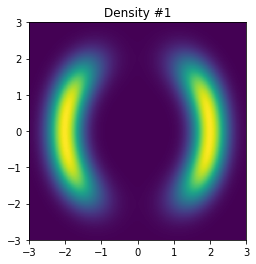

In [43]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

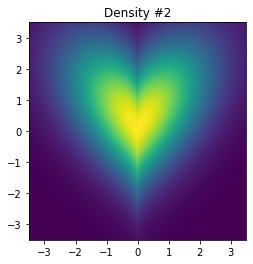

In [44]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz. 

In [45]:
def potential1(z):
    z = z.view(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

In [46]:
def unadjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    for i in tqdm(range(n_samples + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [47]:
samples1 = unadjusted_langevin_algorithm(potential1)
samples2 = unadjusted_langevin_algorithm(potential2)

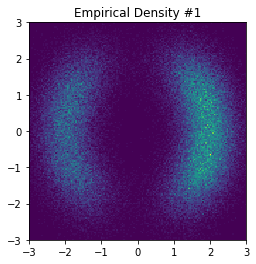

In [48]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

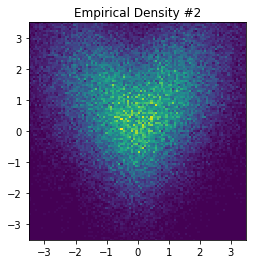

In [49]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-adjusted Langevin Algorithm (MALA)

New samples are proposed using the Euler-Maruyama scheme as before, but are accepted/rejected using the Metropolis-Hastings algorithm, i.e., the acceptance propability is given by

$$\alpha = \min \left\{1, \frac{p(x_{k+1})Q(x_k|x_{k+1})}{p(x_{k})Q(x_{k+1}|x_{k})}\right\}$$

where 

$$Q(x'|x) \propto \exp\left(-\frac{1}{4\gamma}\|x' - x + \gamma\nabla U(x)\|^2\right)$$

In [50]:
def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

In [51]:
samples1 = metropolis_adjusted_langevin_algorithm(potential1)
samples2 = metropolis_adjusted_langevin_algorithm(potential2)

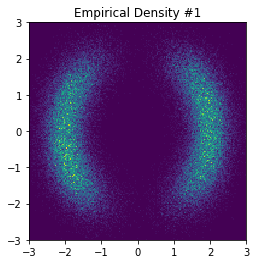

In [52]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

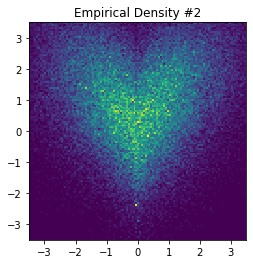

In [53]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-Hastings Algorithm for comparison

In [54]:
def metropolis_hastings(target_density, size=100000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [55]:
samples1 = metropolis_hastings(npdensity1)
samples2 = metropolis_hastings(npdensity2)

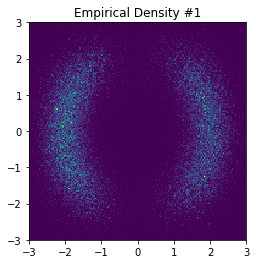

In [56]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

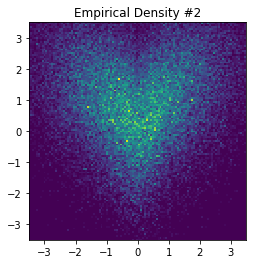

In [57]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()